# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!pwd

/workspace/lectures/spark/notebooks


In [5]:
!hdfs dfs -copyFromLocal /workspace/data/data .

In [6]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-16 21:25 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-16 21:25 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-16 21:25 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-16 21:25 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-16 21:25 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-16 21:25 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-16 21:25 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-16 21:25 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-16 21:25 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [7]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [8]:
ratings = sc.textFile(RATINGS_PATH)

In [9]:
%%time
ratings.take(5)

CPU times: user 7.22 ms, sys: 9.11 ms, total: 16.3 ms
Wall time: 2.24 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [34]:
ratings.getNumPartitions()

5

In [10]:
%%time
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

CPU times: user 22 µs, sys: 7 µs, total: 29 µs
Wall time: 31.7 µs


In [30]:
%%time
ratings.count()

CPU times: user 12.5 ms, sys: 5.47 ms, total: 18 ms
Wall time: 1min 10s


25000095

Количество пользователей

In [31]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 24.3 ms, sys: 6.8 ms, total: 31.1 ms
Wall time: 1min 23s


162541

Сохраним датасет в память

In [35]:
ratings = ratings.persist()

In [36]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 24 ms, sys: 8.98 ms, total: 33 ms
Wall time: 2min 20s


162541

Количество фильмов

In [37]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 12.7 ms, sys: 12.1 ms, total: 24.8 ms
Wall time: 39.5 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [23]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [28]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (198527, (5.0, ['198527', 'Drift (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [30]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [31]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-16 13:26 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59139 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112222 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131258 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114186 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133841 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117681 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143063 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167794 2021-02-16 13:26 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [32]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [34]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [38]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

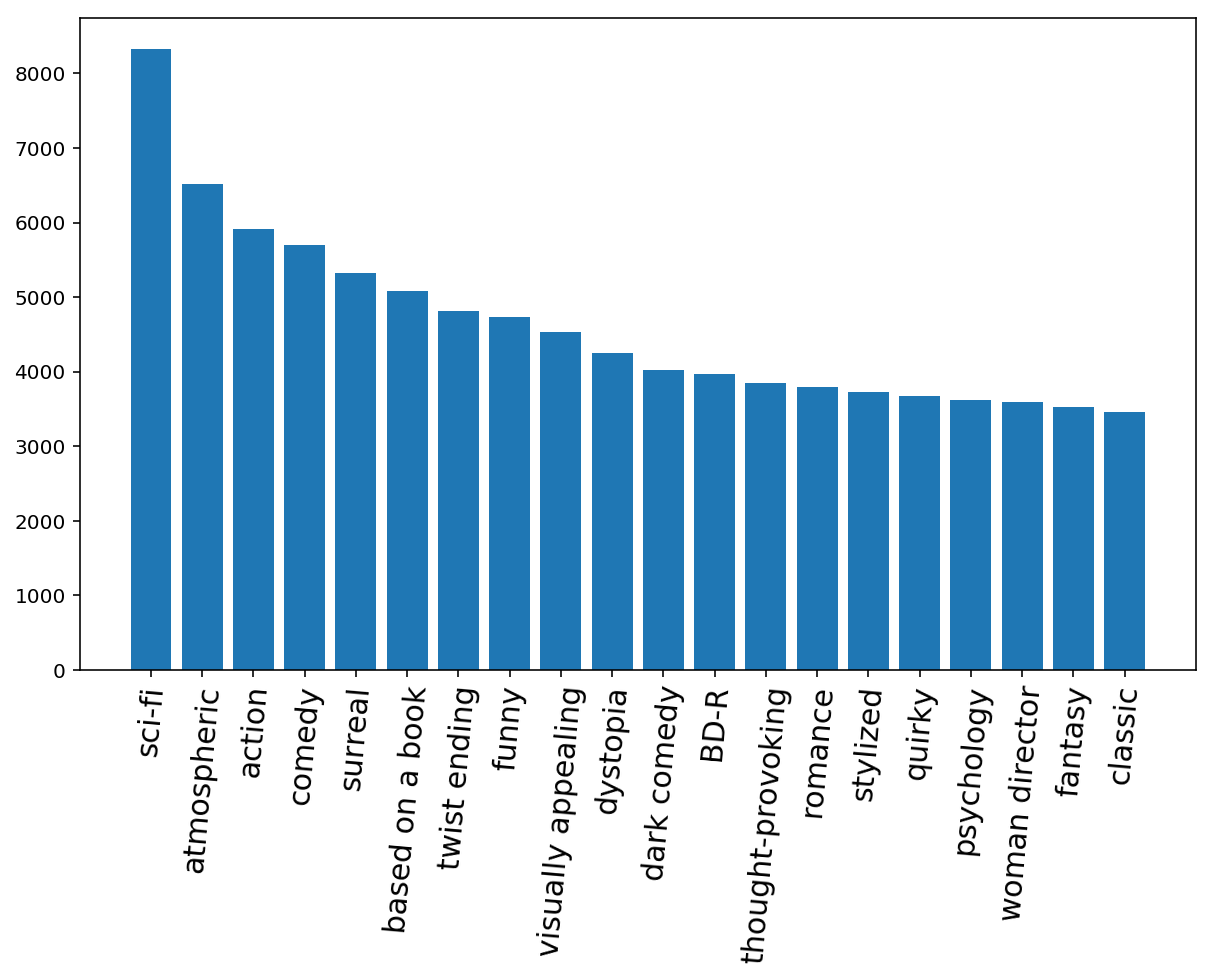

In [39]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [44]:
ratings_cout = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda v1, v2: v1 + v2) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) 

In [54]:
ratings_cout \
    .map(lambda el: (el[1][1][1], el[1][0])).take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [66]:
five_star = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .filter(lambda el: el[1][0] == 5.) \
    .reduceByKey(lambda v1, v2: (5., v1[1] + v2[1])) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0][1], ascending=False)

In [68]:
five_star \
    .map(lambda el: (el[1][1][1], el[1][0][1])).take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [71]:
avg_ratings = movie_avg_rating \
    .map(lambda el: el[1]) \
    .collect()

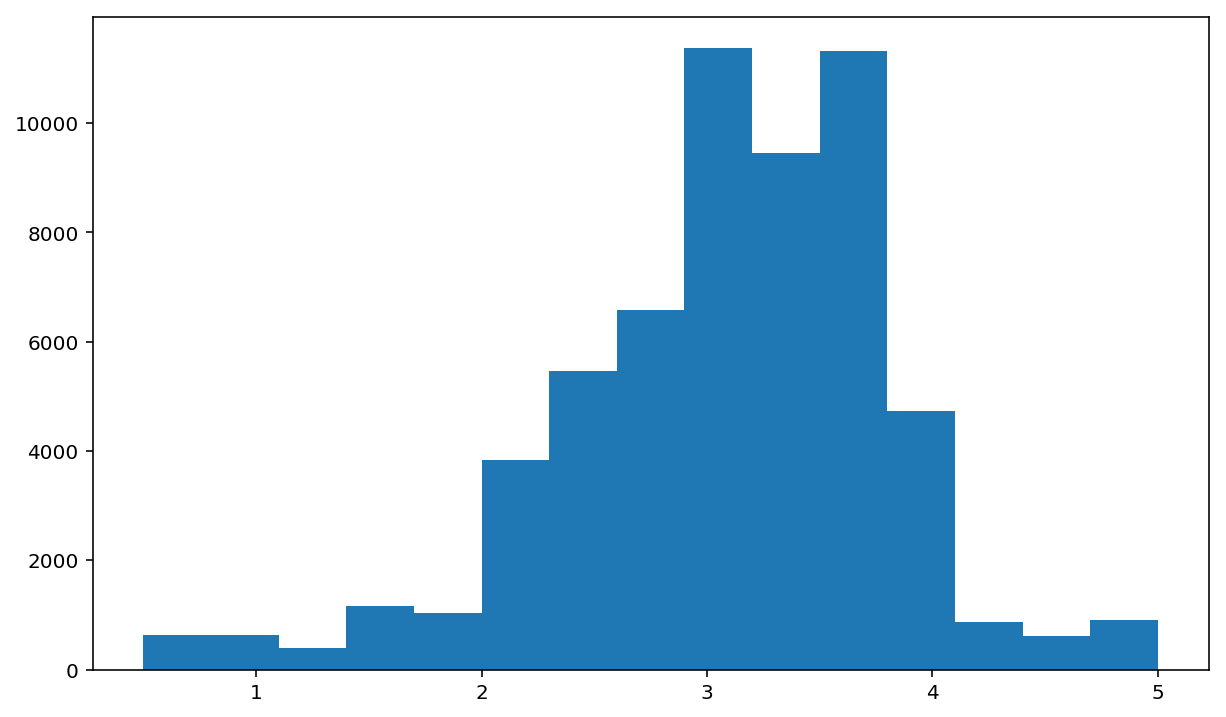

In [82]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(avg_ratings, bins=15)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [84]:
count_ratings = ratings_cout \
    .map(lambda el: el[1][0]) \
    .collect()

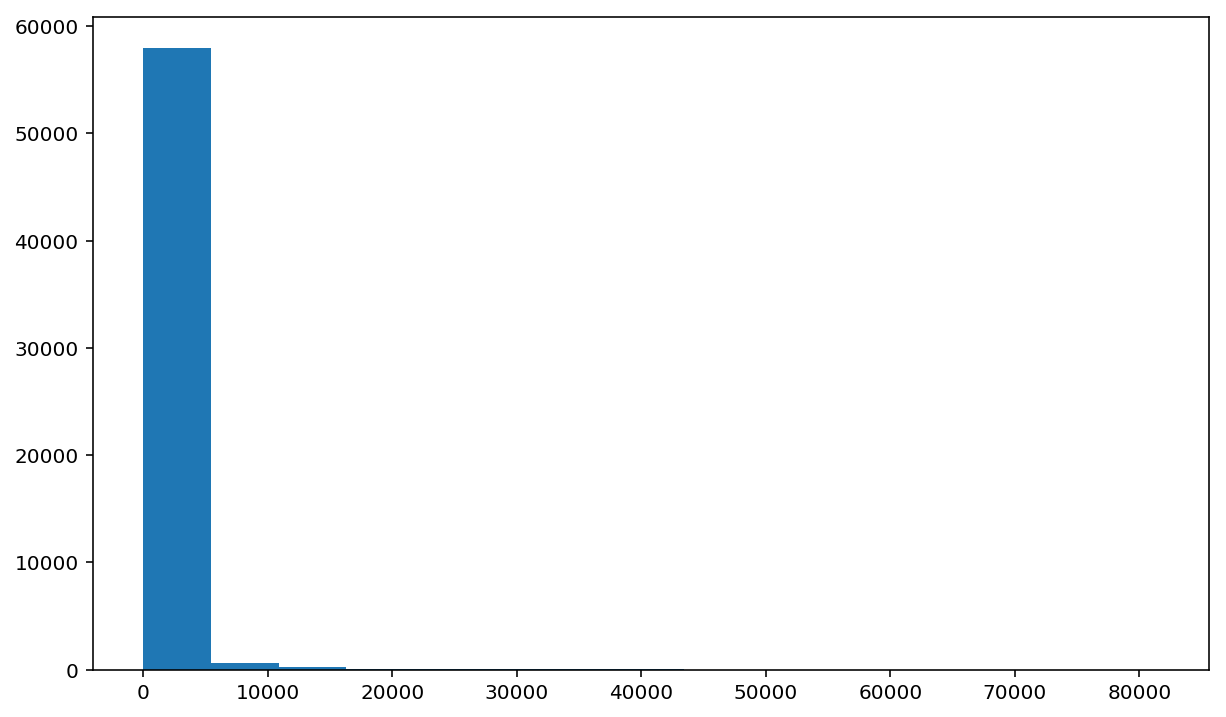

In [89]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(count_ratings, bins=15)
plt.show()

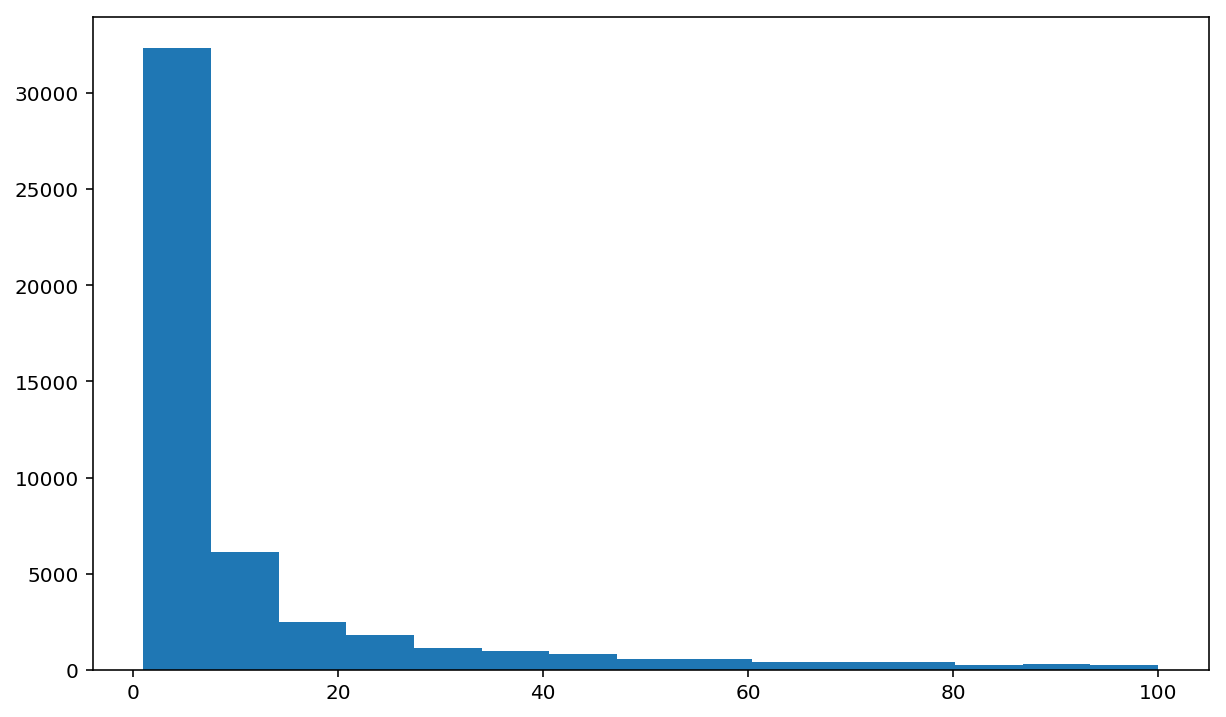

In [94]:
count_ratings_ = [cnt for cnt in count_ratings if cnt <= 100]
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(count_ratings_, bins=15)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [54]:
genres = sc.textFile(MOVIES_PATH)
genres.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [64]:
genres_cnt = genres \
    .map(lambda s: s.split(',')[-1]) \
    .filter(lambda el: el != 'genres') \
    .flatMap(lambda s: s.split('|')) \
    .map(lambda s: (s, 1)) \
    .reduceByKey(lambda v1, v2: v1 + v2) \
    .collect()

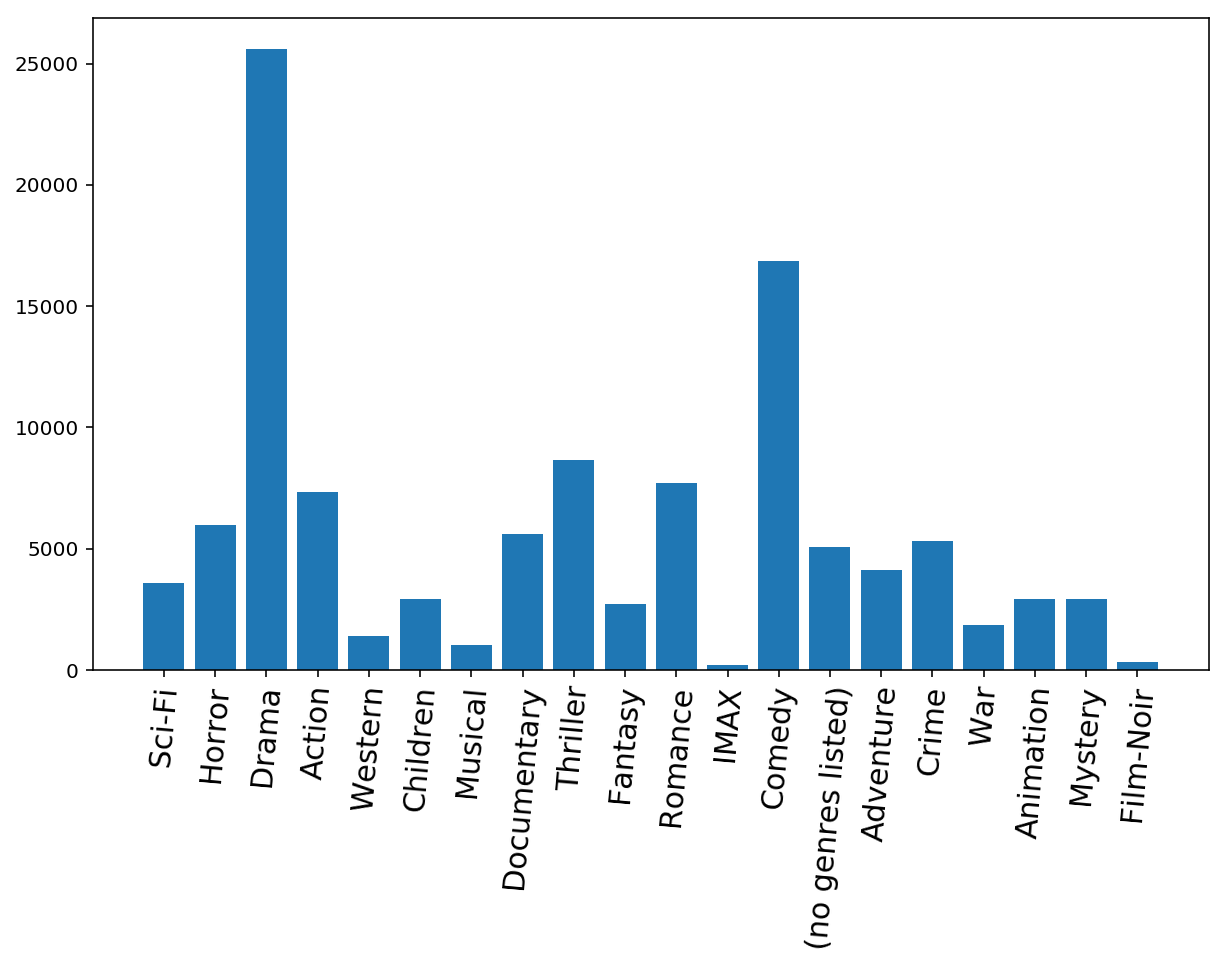

In [69]:
x, y = zip(*genres_cnt)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(x, y)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [8]:
ratings = sc.textFile(RATINGS_PATH)
movies = sc.textFile(MOVIES_PATH)
links = sc.textFile(DATA_PATH + '/links.csv')
tmdb = sqlContext.read.json(DATA_PATH + '/tmdb.json').rdd

In [140]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [153]:
links_ = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda el: el[0].isdigit()) \
    .map(lambda el: (el[0], el[2])) \
    .keyBy(lambda arr: arr[1])

In [154]:
links_.take(5)

[('862', ('1', '862')),
 ('8844', ('2', '8844')),
 ('15602', ('3', '15602')),
 ('31357', ('4', '31357')),
 ('11862', ('5', '11862'))]

In [158]:
tmdb_ = tmdb \
    .filter(lambda el: hasattr(el.casts, "cast")) \
    .filter(lambda el: 31 in [cast.id for cast in el.casts.cast])\
    .map(lambda row: (row.id)) \
    .keyBy(lambda el: str(el))

In [165]:
ids = tmdb_ \
    .join(links_) \
    .map(lambda el: el[1][1][0]) \
    .keyBy(lambda el: int(el))

In [166]:
ids.take(5)

[(143385, '143385'),
 (3525, '3525'),
 (97752, '97752'),
 (2375, '2375'),
 (73472, '73472')]

In [169]:
ids \
    .join(movies) \
    .map(lambda el: el[1][1][1]) \
    .collect()

['Sleepless in Seattle (1993)',
 '"Celluloid Closet',
 'Elvis Has Left the Building (2004)',
 '"\'burbs',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 '"League of Their Own',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Punchline (1988)',
 'Turner & Hooch (1989)',
 '"Simpsons Movie',
 'Larry Crowne (2011)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Toy Story Toons: Small Fry (2011)',
 '"Man with One Red Shoe',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'The Post (2017)',
 '"Money Pit',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'Radio Flyer (1992)',
 'California Typewriter (2017)',
 'Apollo 13 (1995)',
 '"Pixar Story',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The Mayo Clinic',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 '"Ladykillers',
 '

In [173]:
tmdb \
    .filter(lambda el: hasattr(el.casts, "cast")) \
    .flatMap(lambda el: [cast.name for cast in el.casts.cast]) \
    .map(lambda el: (el, 1)) \
    .reduceByKey(lambda v1, v2: v1 + v2) \
    .sortBy(lambda key_value: key_value[1], ascending=False).take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [11]:
genres = tmdb \
    .filter(lambda el: el.genres) \
    .flatMap(lambda el:  [genre.name for genre in el.genres]) \
    .distinct() \
    .collect()

In [17]:
genres_dict = {genres[i]: i for i, genre in enumerate(genres)}

In [29]:
def encode(arr):
    out = [0 for i in range(len(genres))]
    for el in arr:
        out[genres_dict[el]] = 1
    return out

In [31]:
def sum_(a1, a2):
    out = [0 for i in range(len(a1))]
    for i in range(len(a1)):
        out[i] = a1[i] + a2[i]
    return out

In [46]:
def ratio(arr):
    out = [0 for i in range(len(arr))]
    for i, el in enumerate(arr):
        out[i] = el / sum(arr)
    return out

In [36]:
encodings = tmdb \
    .filter(lambda el: el.genres) \
    .filter(lambda el: el.release_date) \
    .map(lambda el: (el.release_date[:4], [genre.name for genre in el.genres])) \
    .map(lambda el: (el[0], encode(el[1]))) \
    .reduceByKey(lambda v1, v2: sum_(v1, v2)) 

In [48]:
ratios = encodings \
    .mapValues(lambda el: ratio(el)) \
    .sortBy(lambda key_value: key_value[0]) \
    .collect()

In [81]:
x, y = zip(*ratios)
x = [int(el) for el in x]
y = list(map(list, zip(*y)))

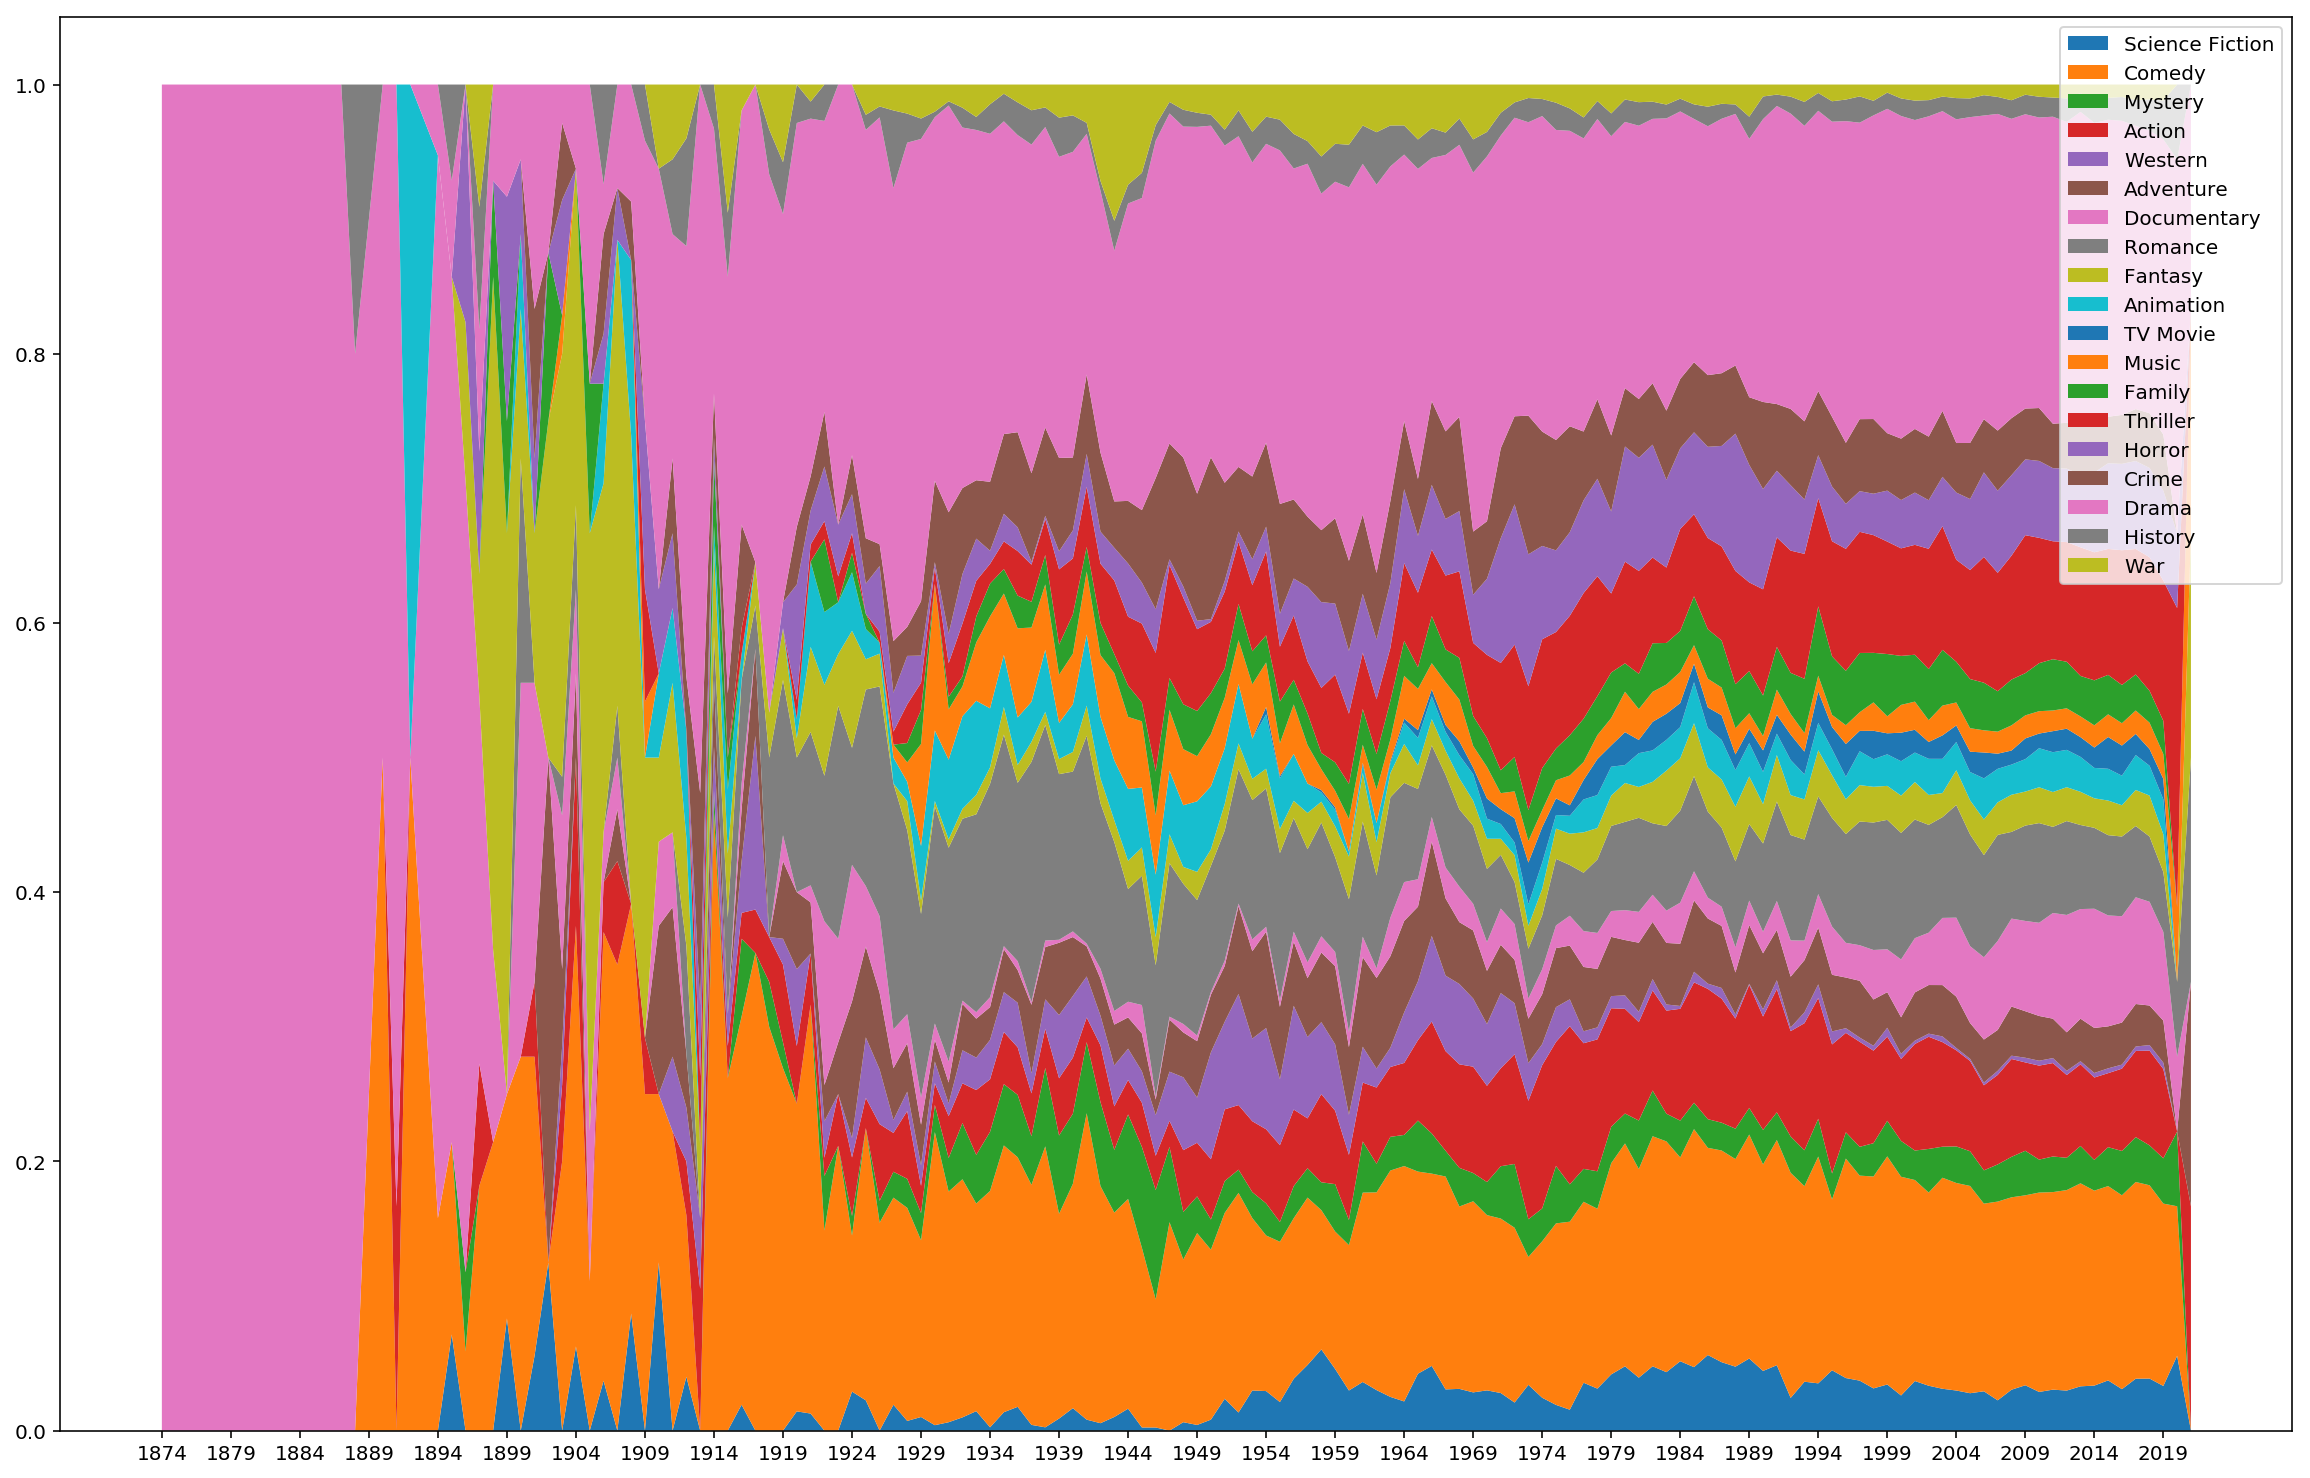

In [85]:
f, ax = plt.subplots(figsize=(20, 13))
plt.stackplot(x, *y, labels=genres)
plt.xticks([i for i in range(min(x), max(x)+1, 5)])
plt.legend()
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [91]:
roi = tmdb \
    .filter(lambda el: el.genres and el.revenue and el.budget) \
    .flatMap(lambda el: [(genre.name, (el.revenue, el.budget)) for genre in el.genres]) \
    .reduceByKey(lambda v1, v2: (v1[0] + v2[0], v1[1] + v2[1])) \
    .mapValues(lambda el: el[0] / el[1]) \
    .collect()

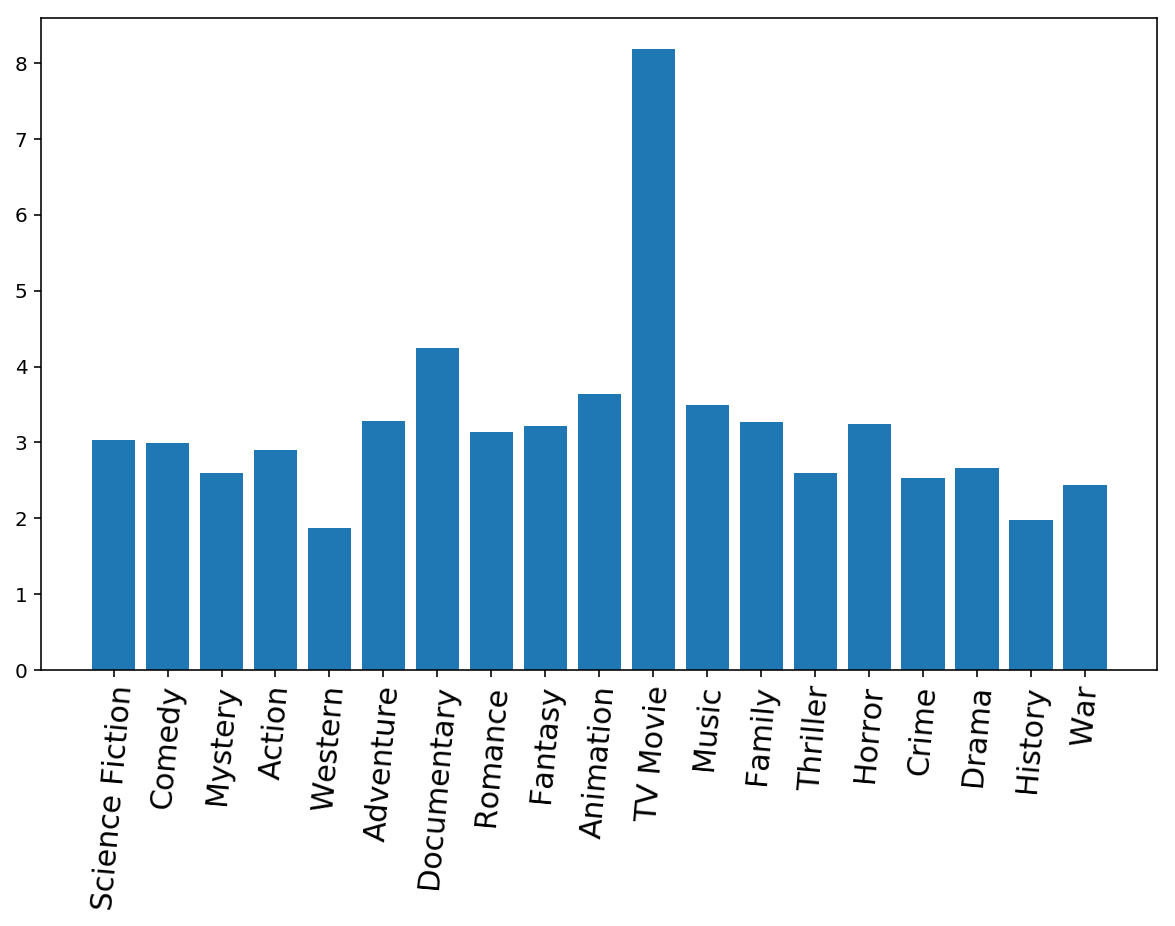

In [93]:
x, y = zip(*roi)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(x, y)
plt.show()